## Chapter 4

In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.interpolate import griddata
import pandas as pd
import arviz as az

C:\Users\Mikko\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\Mikko\AppData\Local\Continuum\anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
%config InLineBackEnd.figure_format = 'retina'
az.style.use('arviz-darkgrid')

Text(0, 0.5, 'Density')

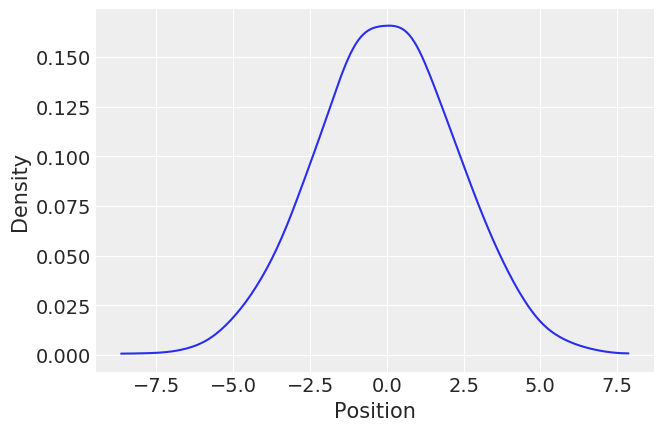

In [3]:
pos = np.random.uniform(-1, 1, size=(16, 10000)).sum(0)
az.plot_kde(pos)
plt.xlabel('Position')
plt.ylabel('Density')

In [4]:
pos=np.random.uniform(1,1.1,size=(12,10000)).prod(0)

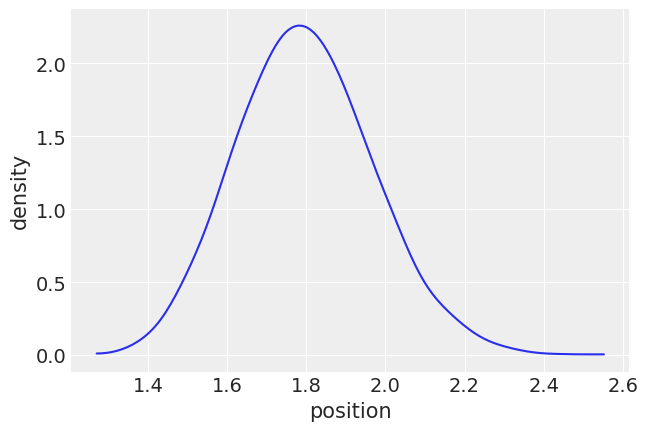

In [5]:
az.plot_kde(pos)
plt.xlabel('position')
plt.ylabel('density');

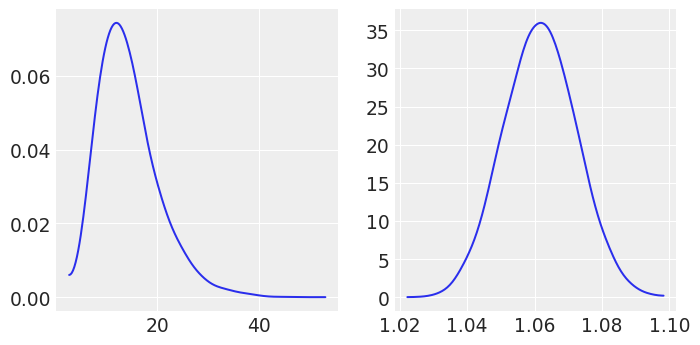

In [6]:
big = np.random.uniform(1,1.5,size=(12,10000)).prod(0)
small = np.random.uniform(1,1.01, size=(12,10000)).prod(0)
_, ax = plt.subplots(1,2,figsize=(8,4))
az.plot_kde(big,ax=ax[0])
az.plot_kde(small, ax=ax[1]);

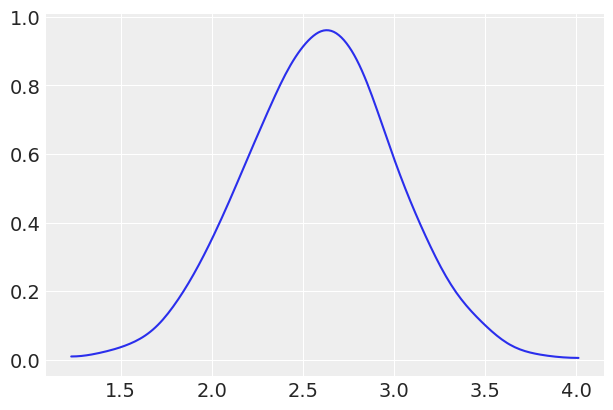

In [7]:
log_big=np.log(np.random.uniform(1,1.5,size=(12,10000)).prod(0))
az.plot_kde(log_big)

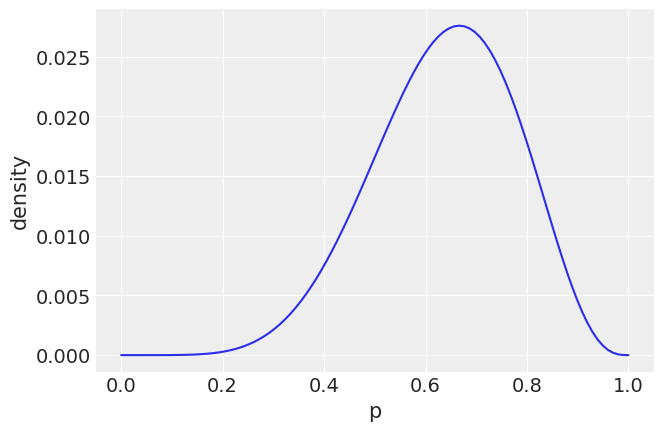

In [8]:
w, n = 6,9
grid = np.linspace(0,1,100)
posterior = stats.binom.pmf(w,n,grid) * stats.uniform.pdf(grid,0,1)
posterior = posterior/posterior.sum()
plt.plot(grid, posterior)
plt.xlabel('p')
plt.ylabel('density');

In [9]:
d = pd.read_csv("../resources/Rethinking/Data/Howell1.csv", sep = ';', header = 0)
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [10]:
d['height'].head()

0    151.765
1    139.700
2    136.525
3    156.845
4    145.415
Name: height, dtype: float64

In [11]:
d2=d[d['age']>18]

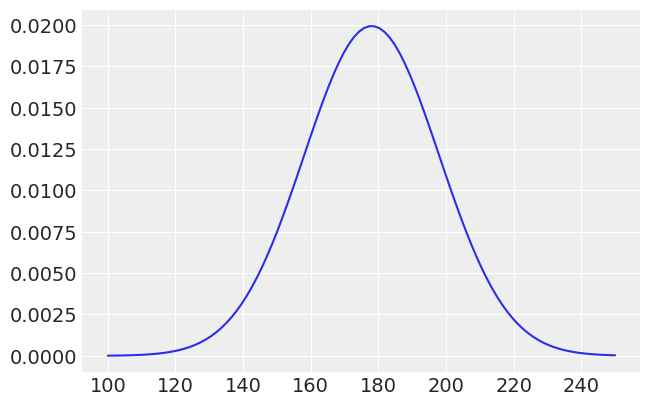

In [12]:
x = np.linspace(100,250,100)
plt.plot(x,stats.norm.pdf(x,178,20))

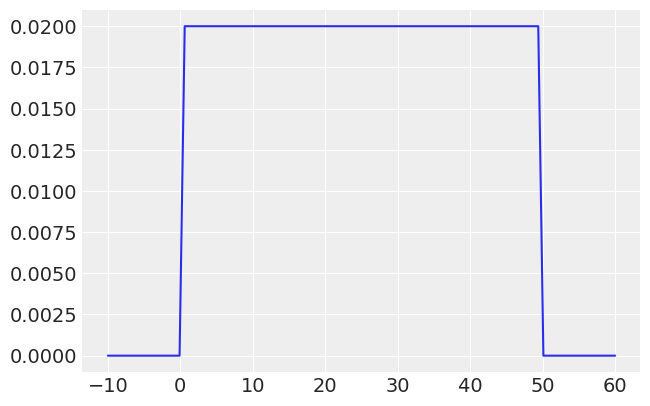

In [13]:
x= np.linspace(-10,60,100)
plt.plot(x,stats.uniform.pdf(x,0,50))

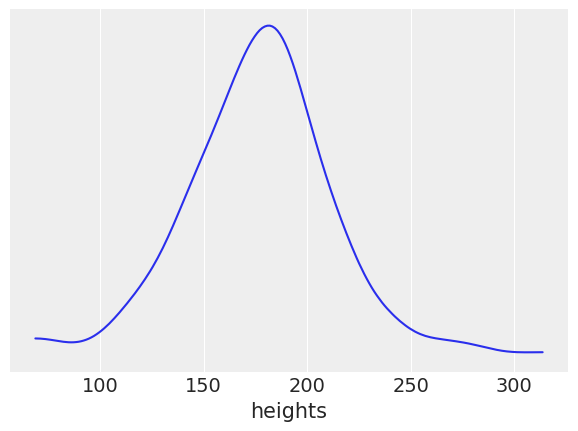

In [14]:
n_samples = 1000
sample_mu = stats.norm.rvs(loc=178, scale=20, size = n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size = n_samples)
prior_h = stats.norm.rvs(loc = sample_mu, scale = sample_sigma)
az.plot_kde(prior_h)
plt.xlabel('heights')
plt.yticks([]);

In [15]:
post = np.mgrid[140:160:0.1, 4:9:0.1].reshape(2,-1).T

In [16]:
post

array([[140. ,   4. ],
       [140. ,   4.1],
       [140. ,   4.2],
       ...,
       [159.9,   8.7],
       [159.9,   8.8],
       [159.9,   8.9]])

In [17]:
likelihood = [sum(stats.norm.logpdf(d2.height, loc = post[:,0][i], scale = post[:,1][i])) for i in range(len(post))]

In [18]:
post_prod = (likelihood+stats.norm.logpdf(post[:,0], loc=178, scale = 20) + stats.uniform.logpdf(post[:,1], loc = 0, scale = 50))

In [19]:
post_prob = np.exp(post_prod - max(post_prod))

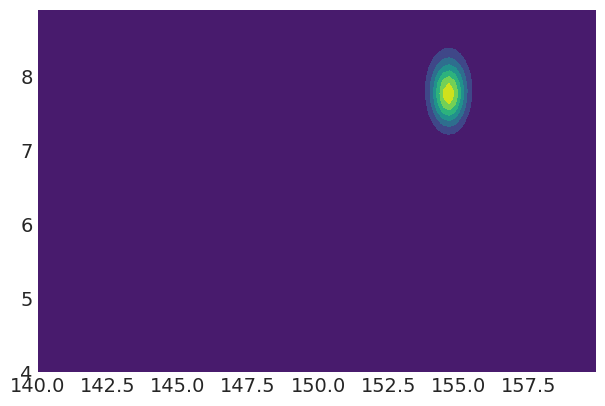

In [20]:
xi = np.linspace(post[:,0].min(), post[:,0].max(), 100)
yi = np.linspace(post[:,1].min(), post[:,1].max(), 100)
zi = griddata((post[:,0], post[:,1]), post_prob, (xi[None,:], yi[:,None]))

plt.contourf(xi, yi, zi);


In [21]:
sample_rows = np.random.choice(np.arange(len(post)), size = 10000, p=post_prob/(post_prob.sum()))

In [22]:
sample_mu = post[:,0][sample_rows]
sample_sigma = post[:,1][sample_rows]

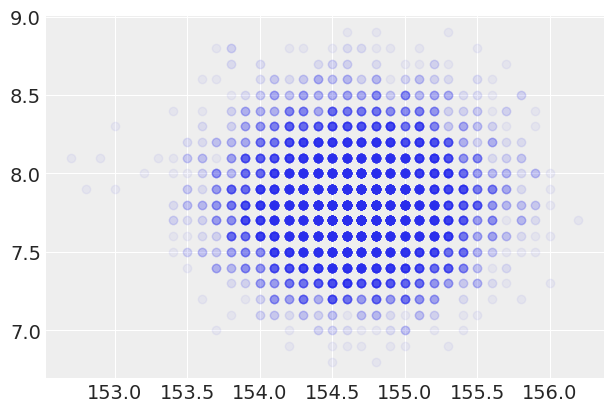

In [23]:
plt.plot(sample_mu, sample_sigma, 'o', alpha = 0.05)

Text(0.5, 0, 'sample sigma')

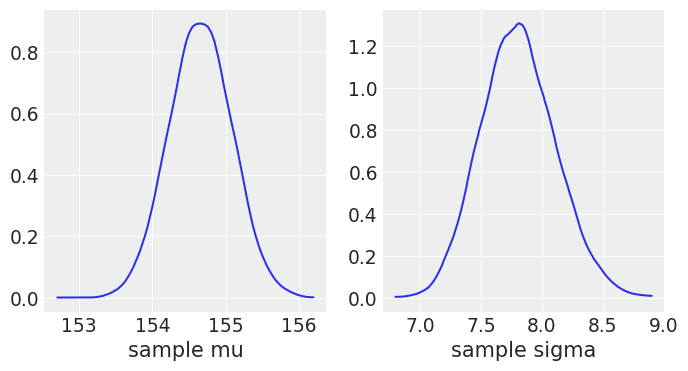

In [24]:
_, ax = plt.subplots(1,2, figsize=(8,4))
az.plot_kde(sample_mu,ax=ax[0])
az.plot_kde(sample_sigma, ax=ax[1])
ax[0].set_xlabel('sample mu')
ax[1].set_xlabel('sample sigma')

In [25]:
d = pd.read_csv('../resources/Rethinking/Data/Howell1.csv', sep = ';', header = 0)

In [26]:
d2 = d[d.age >= 18]

In [27]:
with pm.Model() as m4_1:
    mu = pm.Normal('mu', mu=178, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)

In [30]:
with m4_1:
    trace_4_1 = pm.sample(1000, tune = 1000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:06<00:00, 1216.01draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000180DF0DCCF8>,
      dtype=object)

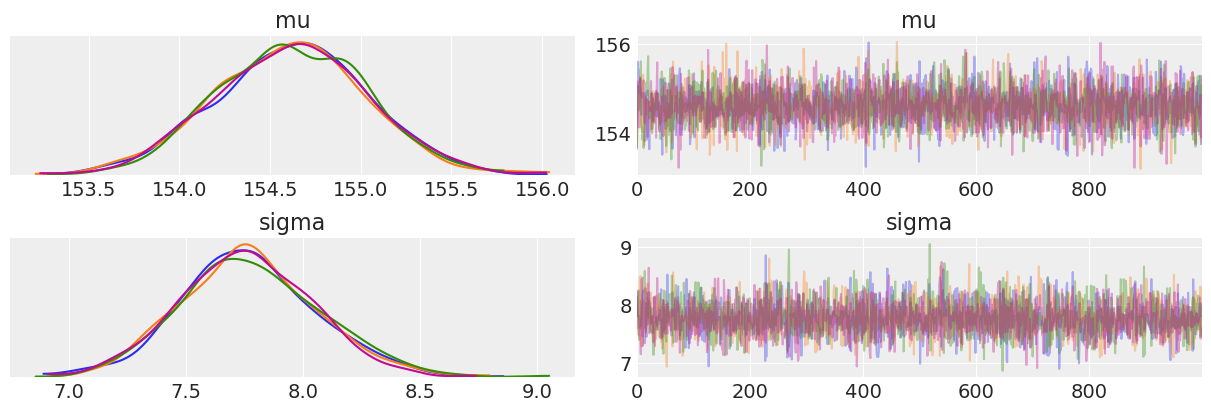

In [33]:
az.plot_trace(trace_4_1)

In [35]:
az.summary(trace_4_1, credible_interval = .89 , ).round(2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,154.62,0.42,154.00,155.32,0.01,0.0,4260.0,4260.0,4235.0,3074.0,1.0
sigma,7.77,0.29,7.32,8.23,0.00,0.0,3782.0,3761.0,3807.0,2505.0,1.0


In [39]:
with pm.Model() as m4_2:
    mu = pm.Normal('mu', mu = 178, sd = 0.1)
    sigma = pm.Uniform('sigma', lower = 0, upper = 50)
    height = pm.Normal('height', mu = mu, sd=sigma, observed = d2.height)
    trace_4_2 = pm.sample(1000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1350.44draws/s]


In [42]:
y = np.array([1,2,3,4])
with pm.Model() as model:
    N = pm.DiscreteUniform('N', lower = y.max(), upper = y.max()* 20)
    y_obs = pm.DiscreteUniform('y', lower = 0, upper = N, observed = y)
    trace = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [N]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:18<00:00, 2285.06draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [44]:
az.summary(trace_4_2, credible_interval = .89).round(2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,177.86,0.10,177.7,178.01,0.00,0.00,3886.0,3886.0,3900.0,3161.0,1.0
sigma,24.58,0.93,23.1,26.03,0.01,0.01,4119.0,4091.0,4154.0,2919.0,1.0


In [45]:
trace_df = pm.trace_to_dataframe(trace_4_1)
trace_df.cov()

,mu,sigma
mu,0.173141,-0.002096
sigma,-0.002096,0.083344


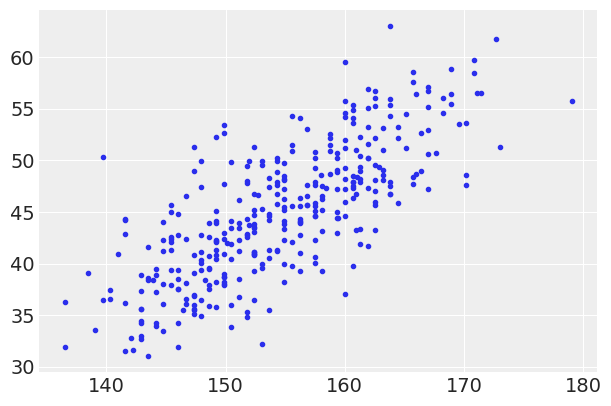

In [46]:
plt.plot(d2.height, d2.weight, '.')